### Conponents of the Linear Path in Flow Matching
0. Source Distribution $p_0$ which is always a gaussian distribution & Target distribution $p_1$ which is always data distribution
1. Conditional Probability Path: $\phi(x_0, x_1)$

2. Flow ODE: $\frac{d\phi(x_0, x_1)}{dt}=v(x_0, x_1)$

3. Loss Function: $L_{CFM}(\theta)=E_{t,q(x),p_t(x|x_1)}||v_t(x_t)-u_t(x_t|x_1)||^2$

4. ODE Solver

In [2]:
import torch
import numpy as np
from torch import nn, Tensor
import time

# visualization
import matplotlib.pyplot as plt
from matplotlib import cm


if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

torch.manual_seed(42)

Using gpu


#### Conditional Path in Flow Matching: $x_t = (1-t)x_0 + (t)x_1, \space x_0 \sim N(0, I)$

In [3]:
class LinearPath():
    def __init__(self, alpha_1=1, sigma_1=0.0):
        self.alpha_1 = alpha_1
        self.sigma_1 = sigma_1
    
    def _compute_alpha_t(self, t):
        alpha_t = t
        d_alpha_t = 1
        return alpha_t, d_alpha_t

    def _compute_sigma_t(self, t):
        sigma_t = 1-t
        d_sigma_t = -1
        return sigma_t, d_sigma_t

    def compute_xt(self, t, x0, x1):
        assert x0.shape == x1.shape
        B, num_fea = x0.shape
        t = t.reshape(B,1)
        alpha_t, _ = self._compute_alpha_t(t)
        sigma_t, _ = self._compute_sigma_t(t)

        xt = sigma_t * x0 + alpha_t * x1

        return xt
    
    def compute_ut(self, t, x0, x1):
        assert x0.shape == x1.shape

        _ , d_alpha_t = self._compute_alpha_t(t)
        _ , d_sigma_t = self._compute_sigma_t(t)

        ut = d_alpha_t * x1 + d_sigma_t * x0

        return ut

#### Prepare Data

In [4]:
def inf_train_gen(batch_size: int = 200, device: str = "cpu"):
    x1 = torch.rand(batch_size, device=device) * 4 - 2
    x2_ = torch.rand(batch_size, device=device) - torch.randint(high=2, size=(batch_size, ), device=device) * 2
    x2 = x2_ + (torch.floor(x1) % 2)

    data = 1.0 * torch.cat([x1[:, None], x2[:, None]], dim=1) / 0.45
    
    return data.float()

#### Prepare Model

In [5]:
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor: 
        return torch.sigmoid(x) * x

# Model class
class MLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
            )
    

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)
        
        return output.reshape(*sz)

#### Train velocity flow matching model using linear conditional probability path

In [6]:
# training arguments
lr = 0.001
batch_size = 4096
iterations = 10001
print_every = 2000 
hidden_dim = 512

# velocity field model init
model = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device) 

# instantiate an affine path object
path = LinearPath()

# init optimizer
optim = torch.optim.Adam(model.parameters(), lr=lr) 

# train
start_time = time.time()
for i in range(iterations):
    optim.zero_grad() 

    # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
    x_1 = inf_train_gen(batch_size=batch_size, device=device) # sample data
    x_0 = torch.randn_like(x_1).to(device)

    # sample time (user's responsibility)
    t = torch.rand(x_1.shape[0]).to(device) 

    x_t = path.compute_xt(t, x_0, x_1)

    # 
    predicted_velocity = model(x_t, t)
    
    # sample probability path
    ut = path.compute_ut(t, x_0, x_1)

    # flow matching l2 loss
    loss = torch.pow((predicted_velocity - ut), 2).mean() 

    # optimizer step
    loss.backward() # backward
    optim.step() # update
    
    # log loss
    if (i+1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} ' 
              .format(i+1, elapsed*1000/print_every, loss.item())) 
        start_time = time.time()

/home/fangtongcheng/miniconda3/envs/udit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


| iter   2000 |  4.40 ms/step | loss    3.772 
| iter   4000 |  4.39 ms/step | loss    3.684 
| iter   6000 |  4.14 ms/step | loss    3.780 
| iter   8000 |  4.33 ms/step | loss    3.729 
| iter  10000 |  4.18 ms/step | loss    3.705 


#### Sample: solve the flow ode:$\frac{d\phi(x_0, x_1)}{dt}=v(x_0, x_1)$ via euler method

In [12]:
# Define ODE equation
def fn(t, x, model):
    # return velocity 
    model_output = model(x, t)  # drift and diffusion term
    return model_output

In [42]:
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Euler method for solving ODEs
def euler_method(f, x0, t0, t_end, h, model):
    """
    Euler method for solving first-order ODEs.

    Parameters:
    f (function): The differential equation function f(t, y).
    x0 (torch.Tensor): Initial value of y.
    t0 (float): Initial time.
    t_end (float): End time.
    h (float): Step size.

    Returns:
    t_values (torch.Tensor): Tensor of time values.
    y_values (torch.Tensor): Tensor of y values at each time step.
    """
    t_values = torch.arange(t0, t_end + h, h, device=x0.device)
    x_values = torch.zeros((len(t_values), *x0.shape), device=x0.device)
    x_values[0] = x0

    for i in range(1, len(t_values)):
        x_values[i] = x_values[i-1] + h * f(t_values[i-1], x_values[i-1], model)

    return t_values, x_values

# Input parameters
step_size = 0.01  # Step size for the ODE solver
batch_size = 10000  # Batch size
eps_time = 1e-2
T = torch.linspace(0, 1, 20)  # Sample times
T = T.to(device=device)
x_init = torch.randn((batch_size, 2), dtype=torch.float32, device=device)  # Initial values

# Solve the ODE using the Euler method
t_values, x_values = euler_method(fn, x_init, 0, 1, step_size, model)


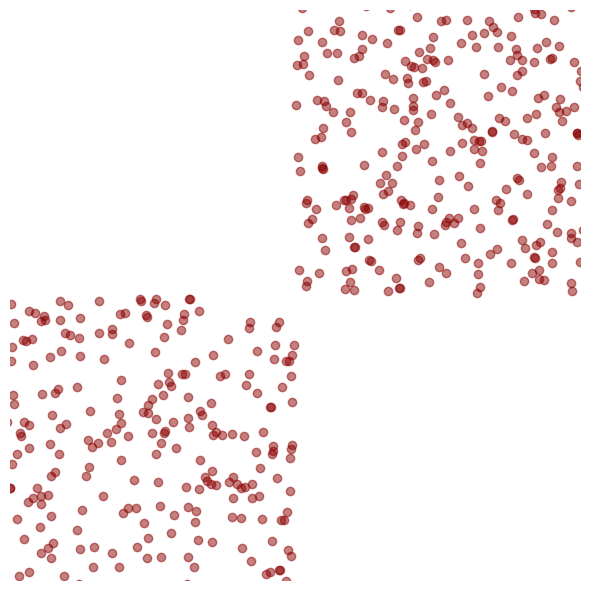

In [46]:
import torch
import matplotlib.pyplot as plt

# 假设 data 是一个形状为 (batch_size, 2) 的张量
data = inf_train_gen(batch_size=batch_size, device=device)  # 生成数据

# 可视化
fig, ax = plt.subplots(figsize=(6, 6))  # 创建一个图像
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_facecolor('white')  # 设置背景颜色为白色
ax.scatter(data[:, 0].cpu().numpy(), data[:, 1].cpu().numpy(), c='darkred', alpha=0.5)  # 设置样本点颜色为深红色
ax.axis('off')  # 移除坐标轴

plt.tight_layout()
plt.show()


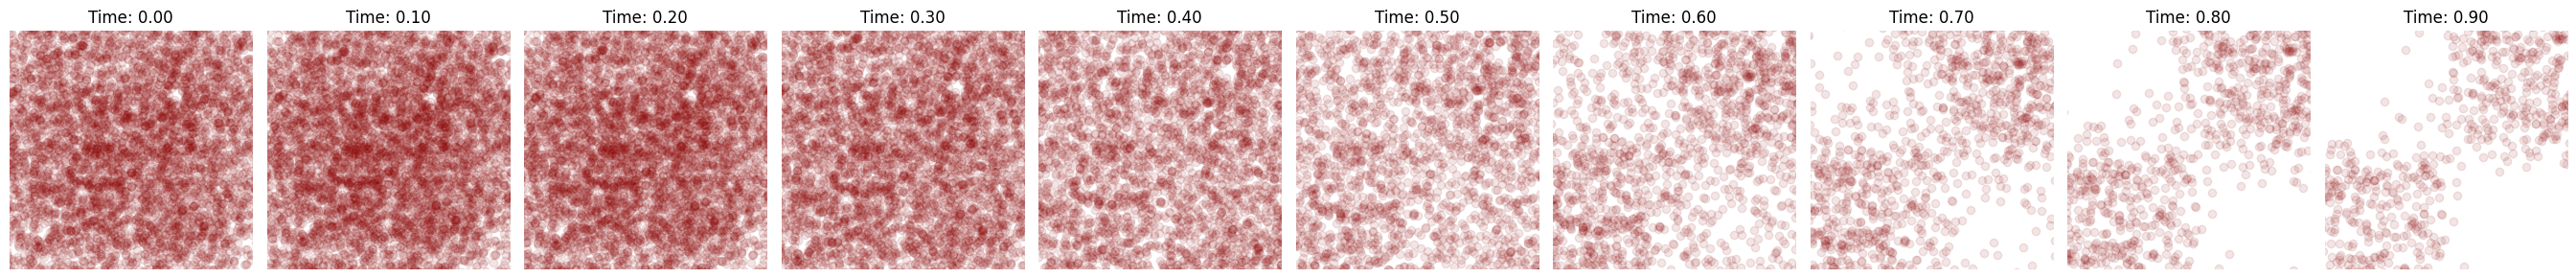

In [44]:
# Visualization
fig, axes = plt.subplots(1, len(t_values)//10, figsize=(27, 3))  # Create a subplot for each 4th time step
norm = cm.colors.Normalize(vmax=50, vmin=0)
cmap = cm.Reds

x_values = x_values.detach()

# Plot every 4th time step
for i, ax in enumerate(axes):
    time_step = i * 10
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title(f'Time: {t_values[time_step]:.2f}')
    ax.set_facecolor('white')  # Set the background color to white
    ax.scatter(x_values[time_step, :, 0].cpu().numpy(), x_values[time_step, :, 1].cpu().numpy(), 
               c='darkred', alpha=0.1)  # Set the sample points color to dark red
    ax.axis('off')  # Remove axis

plt.tight_layout()
plt.show()
